Example of running plink score from Shoa

<code>
plink2 \

  --pfile /oak/stanford/projects/ukbb/genotypes/pgen_app13721_v3/ukb_imp_chr${chr}_v3.mac1 \
  --score metaGRS.UkbbMap.txt 1 2 3 \
  header-read \
  cols=+scoresums \
  --threads 6 \
  --memory 30000 \
  --out chr${chr}
</code>


Generate score file for metaGRS to use in plink

In [ ]:
os.chdir("/labs/tassimes/rodrigoguarischi/projects/sea/apply_grs/plink_comparison")

# # Create key as chr, position, ref allele and alternative allele
# !zcat /labs/tassimes/rodrigoguarischi/projects/sea/apply_grs/pgs_reference_weights/PGS000018.txt.gz | grep -v "^#" | tail -n +2 | awk '{ print $2":"$3"_"$4"_"$5"\t"$4"\t"$6 }' > metaGRS.plink_scores_chrposrefalt.txt

# Create key as chr and position
!zcat /labs/tassimes/rodrigoguarischi/projects/sea/apply_grs/pgs_reference_weights/PGS000018.txt.gz | grep -v "^#" | tail -n +2 | awk '{ print $2":"$3"\t"$4"\t"$6 }' > metaGRS.plink_scores_chrpos.txt
!zcat /labs/tassimes/rodrigoguarischi/projects/sea/apply_grs/pgs_reference_weights/PGS000349.txt.gz | grep -v "^#" | tail -n +2 | awk '{ print $2":"$3"\t"$4"\t"$6 }' > PGS000349.plink_scores_chrpos.txt
!zcat /labs/tassimes/rodrigoguarischi/projects/sea/apply_grs/pgs_reference_weights/wGRS49.txt.gz | grep -v "^#" | tail -n +2 | awk '{ print $2":"$3"\t"$4"\t"$6 }' > wGRS49.plink_scores_chrpos.txt

In [ ]:
score_name = 'metaGRS'
# score_name='PGS000349'
# score_name='wGRS49'

# load necessary modules
module load plink2

# Calculate score for each chromosome
for chr_id in $(seq 1 22); do

  echo -e "Calculating scores for chr${chr_id}";

  plink2 \
    --vcf /labs/tassimes/elyas/SEA/Mach/HRC-imputation/chr${chr_id}.dose.vcf.gz \
    --score ${score_name}.plink_scores_chrpos.txt 1 2 3 \
    cols=+scoresums \
    --rm-dup exclude-all \
    --threads 6 \
    --memory 30000 \
    --out sea_${score_name}_chr${chr_id};

  done

In [1]:
import glob
import pandas as pd

os.chdir("/labs/tassimes/rodrigoguarischi/projects/sea/apply_grs/plink_comparison")

li = []

# Read all sscore files
for current_sscore_file in glob.glob( "sea_metaGRS_*.sscore" ):
    
    current_sscore = pd.read_table( current_sscore_file )
    chr_id_scores = current_sscore_file.split(".")[0].split("_")[-1]

    chromosome_scores = pd.DataFrame( {
        "sample":current_sscore["#IID"].str.split( "_", expand=True )[0],
        chr_id_scores:current_sscore["SCORE1_SUM"]
        } )
    chromosome_scores.set_index("sample", inplace=True)
    
    li.append( chromosome_scores )
    
# Concatenate everything on pandas dataframe
sea_plink_scores = pd.concat(li, axis=1)
sea_plink_scores.head()


,chr4,chr1,chr19,chr11,chr13,chr6,chr2,chr15,chr17,chr21,...,chr9,chr20,chr10,chr22,chr14,chr5,chr18,chr7,chr12,chr16
sample,,,,,,,,,,,,,,,,,,,,,
pd10016,-0.051099,0.570344,0.189966,-0.042283,-0.148538,-0.587675,-0.131677,-0.333449,0.102338,-0.017394,...,-0.341824,0.078962,0.136393,0.096963,0.258639,-0.127401,-0.329513,-0.007937,-0.180173,0.185776
pd10018,0.002261,0.674213,0.177681,-0.119257,-0.233929,-0.730629,0.186465,-0.184111,0.251043,-0.129535,...,-0.285972,0.114091,0.033012,0.125650,0.271862,0.002209,-0.221924,0.026552,-0.138771,0.091495
pd10023,-0.162767,0.488691,0.060101,0.078585,-0.148957,-0.535820,0.139832,-0.271452,0.208855,-0.098795,...,-0.264198,0.015685,-0.141237,0.125812,0.209866,-0.040188,-0.335103,-0.020775,-0.204941,0.120064
pd10031,-0.206836,0.404571,0.181857,-0.040573,-0.112303,-0.607105,-0.027931,-0.216316,0.133896,-0.052989,...,-0.319445,0.083223,0.013984,0.115045,0.167591,0.055429,-0.263434,-0.034745,-0.159689,0.096196
pd10037,-0.119988,0.409979,0.082355,-0.019088,-0.145333,-0.576907,0.099910,-0.329527,0.282448,-0.082924,...,-0.432769,0.126118,0.084663,0.124741,0.210338,-0.071731,-0.260753,-0.103814,-0.086088,0.072243


Load SEA data with results from pgs-calc

In [2]:
import os, glob

# Read phenotypes and recode sex and race attributes
sea_phenotypes = pd.read_table( "/labs/tassimes/rodrigoguarischi/projects/sea/raw_files/SEA/SEA_Phase2_Subject_Phenotypes.txt", index_col="seaid" )

sex_recode = {1:"Male", 2:"Female"}
sea_phenotypes = sea_phenotypes.replace({"sex":sex_recode})

race_recode = {1:"White", 2:"Black"}
sea_phenotypes = sea_phenotypes.replace({"race":race_recode})

li = []
li.append(sea_phenotypes)

for current_score_file in glob.glob( "/labs/tassimes/rodrigoguarischi/projects/sea/apply_grs/*.scores.txt" ):
    pgs_results = pd.read_table( current_score_file, sep = "," )
    pgs_results["sample"] = pgs_results["sample"].str.split("_", expand = True)[0]
    pgs_results = pgs_results.set_index("sample")
    min_r2_used = os.path.basename( current_score_file ).split(".")[0].split("_")[-1]
    pgs_results = pgs_results.add_suffix("_" + min_r2_used)

    li.append( pgs_results )
    
sea_merged = pd.concat( li, axis=1)
sea_merged.head()

,dbGaP_SubjID,sex,race,age,agex2,bmi,tf,tr,af,ar,...,PGS000018_r05,wGRS49_r03,PGS000349_r03,PGS000018_r03,wGRS49_r0,PGS000349_r0,PGS000018_r0,wGRS49_r08,PGS000349_r08,PGS000018_r08
pd10016,445969,Female,White,29,841,19.9,6.7,0.0,10.7,0.0,...,0.324026,0.149529,1.083668,0.343971,-0.044109,1.149052,-0.561914,0.260161,0.778918,0.224605
pd10018,445970,Male,White,30,900,28.3,27.3,0.0,22.0,0.0,...,0.618129,0.137262,0.948800,0.778896,0.021375,1.283380,0.114623,0.319703,0.723872,0.273330
pd10023,445971,Male,White,27,729,21.7,27.3,0.0,55.0,0.0,...,0.185574,0.131141,0.541493,0.315836,-0.124543,0.452067,-0.795218,0.125619,0.271395,0.058748
pd10028,445972,Male,Black,31,961,29,16.0,0.0,36.8,14.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pd10031,445973,Male,White,28,784,21.5,20.0,0.0,16.7,0.0,...,0.334045,0.064820,0.549559,0.292540,-0.104558,0.924686,-0.581531,0.002717,0.571243,0.148730


In [3]:
# Concatenate everything on pandas dataframe
sea_all_data = pd.concat([sea_merged, sea_plink_scores.sum( axis = 1 ).rename("plink_score")], axis=1)
sea_all_data.head()


,dbGaP_SubjID,sex,race,age,agex2,bmi,tf,tr,af,ar,...,wGRS49_r03,PGS000349_r03,PGS000018_r03,wGRS49_r0,PGS000349_r0,PGS000018_r0,wGRS49_r08,PGS000349_r08,PGS000018_r08,plink_score
pd10016,445969,Female,White,29,841,19.9,6.7,0.0,10.7,0.0,...,0.149529,1.083668,0.343971,-0.044109,1.149052,-0.561914,0.260161,0.778918,0.224605,-1.320873
pd10018,445970,Male,White,30,900,28.3,27.3,0.0,22.0,0.0,...,0.137262,0.948800,0.778896,0.021375,1.283380,0.114623,0.319703,0.723872,0.273330,-0.640527
pd10023,445971,Male,White,27,729,21.7,27.3,0.0,55.0,0.0,...,0.131141,0.541493,0.315836,-0.124543,0.452067,-0.795218,0.125619,0.271395,0.058748,-1.550954
pd10028,445972,Male,Black,31,961,29,16.0,0.0,36.8,14.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pd10031,445973,Male,White,28,784,21.5,20.0,0.0,16.7,0.0,...,0.064820,0.549559,0.292540,-0.104558,0.924686,-0.581531,0.002717,0.571243,0.148730,-1.335327


Text(0.04304589439804934, -1.4309553750000001, 'R² = 1.0')

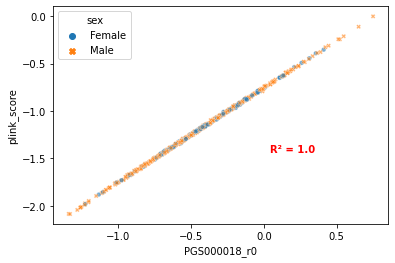

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

var1="PGS000018_r0"
var2="plink_score"

sns.scatterplot(
    x = var1,
    y = var2,
    hue = "sex",
    style = "sex",
    s = 20,
    alpha=0.6,
    data = sea_all_data[ sea_all_data["race"] == "White" ]
)

from scipy.stats import pearsonr

pearson_correlation = pearsonr(sea_all_data[ sea_all_data["race"] == "White" ][var1],sea_all_data[ sea_all_data["race"] == "White" ][var2])[0]

x = numpy.quantile( sea_all_data[ sea_all_data["race"] == "White" ][var1], 0.9)
y = numpy.quantile( sea_all_data[ sea_all_data["race"] == "White" ][var2], 0.25)

plt.text( x, y, "R\u00b2 = "+str(round( pearson_correlation, 3)), size='medium', color='red', weight='semibold')

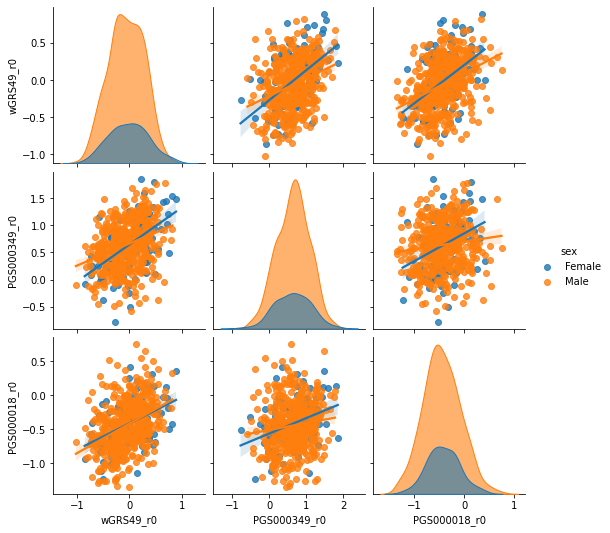

In [24]:
pgss = [ "wGRS49", "PGS000349", "PGS000018" ]
rsq_threshold = "r0"

selected_columns = [sub + "_" + rsq_threshold for sub in pgss]

# sea_all_data[ selected_columns ].head()

sns.pairplot(
  data = sea_all_data,
  vars = selected_columns,
  kind = "reg",
  hue = "sex",
  diag_kws={"alpha":0.6},
  plot_kws={"scatter_kws": {"size":20} }
)

In [14]:
import os, glob
import pandas as pd


# Read phenotypes and recode sex and race attributes
sea_phenotypes = pd.read_table( "/labs/tassimes/rodrigoguarischi/projects/sea/raw_files/SEA/SEA_Phase2_Subject_Phenotypes.txt", index_col="seaid" )

sex_recode = {1:"Male", 2:"Female"}
sea_phenotypes = sea_phenotypes.replace({"sex":sex_recode})

race_recode = {1:"White", 2:"Black"}
sea_phenotypes = sea_phenotypes.replace({"race":race_recode})

sea_clases = pd.read_table( 
    "/labs/tassimes/rodrigoguarischi/projects/sea/data_preparation/sea/86679/NHLBI/SEA_Herrington/phs000349v1/p1/phenotype/phs000349.v1.pht002189.v1.p1.SEA_Phase2_Subject.MULTI.txt",
    index_col="seaid",
    comment='#'
    )

sea_phenotypes_merged = pd.concat( [sea_phenotypes, sea_clases], axis=1)

sea_phenotypes_merged.head()

,dbGaP_SubjID,sex,race,age,agex2,bmi,tf,tr,af,ar,cf,cr,rltotal,rlmean,dbGaP SubjID,consent,subj_source,source_subjid,case
seaid,,,,,,,,,,,,,,,,,,,
pd10016,445969,Female,White,29,841,19.9,6.7,0.0,10.7,0.0,3.3,0.0,0.0,0.000000,445969,1,PDAY,pd10016,0
pd10018,445970,Male,White,30,900,28.3,27.3,0.0,22.0,0.0,3.4,0.6,0.6,0.200000,445970,1,PDAY,pd10018,0
pd10023,445971,Male,White,27,729,21.7,27.3,0.0,55.0,0.0,4.0,0.0,0.0,0.000000,445971,1,PDAY,pd10023,0
pd10028,445972,Male,Black,31,961,29,16.0,0.0,36.8,14.8,1.7,1.0,15.8,5.266667,445972,1,PDAY,pd10028,1
pd10031,445973,Male,White,28,784,21.5,20.0,0.0,16.7,0.0,0.0,0.0,0.0,0.000000,445973,1,PDAY,pd10031,0


Male: 3.2749999999999977, Female:6.000000000000001.


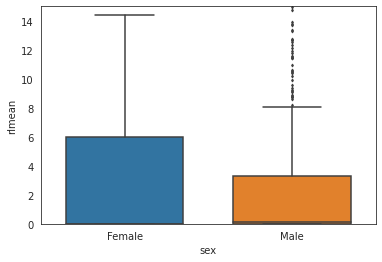

In [48]:
# sea_phenotypes_merged.head()
sea_phenotypes_merged_whites = sea_phenotypes_merged[ sea_phenotypes_merged["race"] == "White" ]

import seaborn as sns

var = "rlmean"

sns.set_style('white')

sns.boxplot(
    x = "sex",
    y = var,
    data = sea_phenotypes_merged_whites,
    width=0.7,
    fliersize=2
    )

import matplotlib.pyplot as plt
plt.ylim(0, 15)

male_quartile = sea_phenotypes_merged_whites[sea_phenotypes_merged_whites["sex"]=="Male"][var].quantile(0.75)
female_quartile = sea_phenotypes_merged_whites[sea_phenotypes_merged_whites["sex"]=="Female"][var].quantile(0.75)

print( "Male: {0}, Female:{1}.".format(male_quartile, female_quartile))
